__In this project we will use Natural Language Processing to classify review of the Yelp review dataset from Kaggle. We will attempt to classify the reviews into 1 to 5 star categories. Each observation in this dataset is  is a review of a particular business by a particular user.__


Let us start with the standard libraries.

In [2]:
import numpy as np
import pandas as pd

In [5]:
doc = pd.read_csv('yelp.csv')

In [6]:
#checking the head of the dataset
doc.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [7]:
doc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


So there are 10000 rows and 10 columns in the dataset

In [8]:
doc.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


As we can see, the average stars is approximately  3.78 with the standard deviation 1.2.

We will create a new column that represents the length of each review from the column 'text'.

In [9]:
doc['text_len'] = doc['text'].apply(len)

In [10]:
# checking the head of the new column
doc['text_len'].head()

0     889
1    1345
2      76
3     419
4     469
Name: text_len, dtype: int64

We will now explore the data. We start by importing the data visualization libraries.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's build histograms using seaborns facegrid.

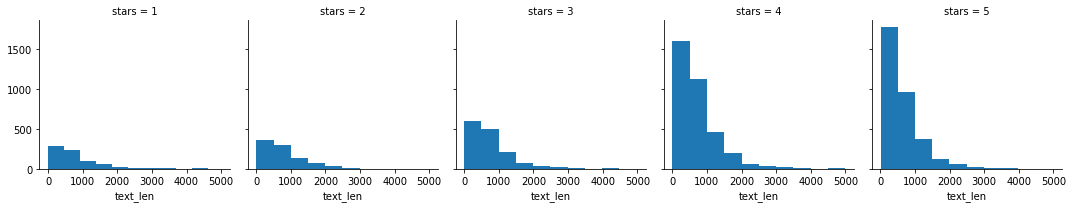

In [12]:
grid = sns.FacetGrid(doc, col = 'stars')
grid.map(plt.hist, 'text_len')

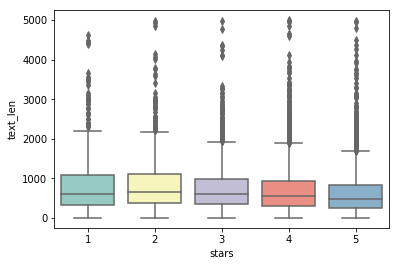

In [13]:
# creating a boxplot
sns.boxplot(data = doc, x = 'stars', y = 'text_len', palette='Set3')

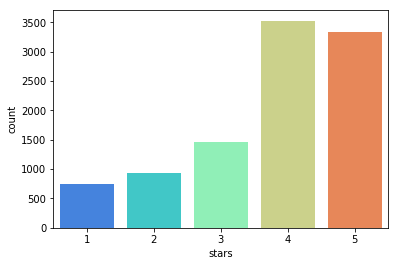

In [14]:
# creating a countplot of the frequences of each type of ratings
sns.countplot(data = doc, x = 'stars', palette = 'rainbow')

__Observations__

__1.__ From the counplot we can see that the majority of the review have 4 or 5 stars. Hence the mean(as we have seen above) is high.

__2.__ We also notice that most of the reviews have length less than 1000. In fact, the boxplot shows that approximately 75% of the reviews have length less than 1000.

We now calculate the means for the numerical columns for each star category.

In [15]:
star_means = doc.groupby('stars').mean()
star_means

,cool,useful,funny,text_len
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


We would like to see how the columns of the star-means are correlated. The correlation function beetween the column vectors is simply the cosine of the angle between them, i.e. it is the ratio of the inner product of the vector and the product of the norms, $Corr (x,y) = \frac{(x,y)}{||x||  ||y||}.$ If the correlation is closer to 1 then $x$ and $y$ are strongly correlated. The calue of the correlation is always between -1 and 1. We can use the built in method corr() to evaluate correlations. Then we can use seaborn to create a heatmap of the correlations.


In [16]:
star_means.corr()

,cool,useful,funny,text_len
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text_len,-0.857664,0.699881,0.843461,1.000000


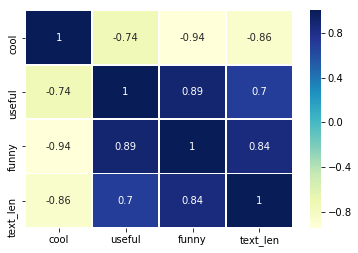

In [25]:
sns.heatmap(star_means.corr(), annot=True, cmap="YlGnBu", linewidths=.7)

We can see that 'funny' and 'useful' columns are stringly correlated while the columns 'cool' and 'text_len' are negatively strongly correlated.

__TEXT PREPROCESSING__

We will be working with sub-frame of the doc dataframe that consists of the star rating, text and the text length.

In [18]:
messages = doc[['stars', 'text', 'text_len']]
messages.head()

,stars,text,text_len
0,5,My wife took me here on my birthday for breakf...,889
1,5,I have no idea why some people give bad review...,1345
2,4,love the gyro plate. Rice is so good and I als...,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",419
4,5,General Manager Scott Petello is a good egg!!!...,469


In [19]:
messages.describe()

,stars,text_len
count,10000.000000,10000.000000
mean,3.777500,710.738700
std,1.214636,617.399827
min,1.000000,1.000000
25%,3.000000,294.000000
50%,4.000000,541.500000
75%,5.000000,930.000000
max,5.000000,4997.000000


In [20]:
messages.groupby('stars').describe()

text_len                                                             
         count        mean         std   min    25%    50%      75%     max
stars                                                                      
1        749.0  826.515354  742.929304  11.0  315.0  600.0  1075.00  4618.0
2        927.0  842.256742  704.079491   7.0  365.5  656.0  1105.00  4972.0
3       1461.0  758.498289  627.594294   1.0  342.0  599.0   975.00  4975.0
4       3526.0  712.923142  600.158476   2.0  307.0  551.5   945.75  4997.0
5       3337.0  624.999101  558.578229   6.0  243.0  471.0   826.00  4986.0

We see that the longest review with star 1 has 4618 words. Let's find that review

In [21]:
messages[messages['text_len'] == 4618]['text'].iloc[0]

'Let me start by saying after my experience I surly wish they had half or quarter stars and I am not often found with a lack of words but this is going to take some effort to stomach.\n\nStrolled into this establishment at about 1:30 am, now to their credit I fully understand the crowd on mill at these hours so I lower my levels of expectations..\n\nPlace is moderately busy as we walk in, I get to the counter, order some pepperoni pizza and a pretzel with 2 drink cups. Second drink cup is forgot after they ran out of the dispenser, after I remind him he gets a fresh stock of cups to replenish his dispenser but first takes his hand, fingers placed inside the cup and hand me one. Yuck.. Gf didn\'t catch it so I gave her the first cup and took the lingering finger taste cup as my own.\n\n\nFast forward a few minutes, guy is in there , his friends are loud and his face is cut wide open from who knows what incident.. He is arguing and finally his friends get him out the door. Now if I ran t

We will now pre-process the reviews. We note some of the words and punctuations do not generally help for predictions. So we can use 'stopwords' to get rid of the unnecessary words and we will drop punctuations as well.

In [25]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\farru\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [26]:
# Let's see some stop words. These are the words that usually do not help predict
stopwords.words('english')[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [32]:
def process_message(message):
    """
    This function takes in a string of text, then performs the followings:
    1. Removes all punctuation
    2. Removes all stopwords
    3. Returns a list of the cleaned text
    """
    # Checking to see if they are in punctuation
    nopunc = [char for char in message if char not in string.punctuation]

    
    nopunc = ''.join(nopunc)
    
    #  removing any stopwords
    out = []
    for word in nopunc.split():
        if word.lower() not in stopwords.words('english'):
            out.append(word)
            
    return out

Let's apply the above function and see if it is working.

In [28]:
# see the head again
messages.head()

,stars,text,text_len
0,5,My wife took me here on my birthday for breakf...,889
1,5,I have no idea why some people give bad review...,1345
2,4,love the gyro plate. Rice is so good and I als...,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",419
4,5,General Manager Scott Petello is a good egg!!!...,469


In [33]:
messages['text'].head(5).apply(process_message)

0    [wife, took, birthday, breakfast, excellent, w...
1    [idea, people, give, bad, reviews, place, goes...
2    [love, gyro, plate, Rice, good, also, dig, can...
3    [Rosie, Dakota, LOVE, Chaparral, Dog, Park, co...
4    [General, Manager, Scott, Petello, good, egg, ...
Name: text, dtype: object

__TEXT TO VECTOR__

Our reviews consists of strings of words. In order to apply SciKit Learn's algorithms we will need to quantify the reviews. This can be done by transforming the reviews into vectors of numbers. This can be done by the following steps:

1. Count how many times does a word occur in each message (term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
bow_transform = CountVectorizer(analyzer=text_process).fit(messages['text'])


print(len(bow_transform.vocabulary_))

44012


Let's choose one review and and represent its bag-of-words as a vector.

In [49]:
message20 = messages['text'][19]
print(message20)
print(len(message20))

They've gotten better and better for me in the time since this review was written. 

My last contact with them was a few days ago when I was having trouble redeeming some Groupons on their website. I called customer service and after waiting a few minutes I spoke with a rep who cheerfully booked four separate flights for me, patiently and manually entering my Groupon info for each one.

I think the acquisition by Republic has helped them overall. After Republic took over the in-flight cookies started. It still tends to suck if you aren't Ascent club (like just about any budget-centric airline does), but once you get there it's a good value. When I've had to fly Southwest or USAir I've been disappointed in comparison.
726


In [48]:
#vector representaion
bow20 = bow_transform.transform([message20])
print(bow20)
print(bow20.shape)

  (0, 1892)	1
  (0, 6507)	1
  (0, 6509)	1
  (0, 7452)	2
  (0, 11449)	2
  (0, 12808)	1
  (0, 13682)	1
  (0, 14091)	1
  (0, 15307)	1
  (0, 15561)	1
  (0, 15619)	1
  (0, 16233)	1
  (0, 17345)	2
  (0, 17780)	1
  (0, 18252)	1
  (0, 18585)	1
  (0, 19204)	1
  (0, 19768)	1
  (0, 20090)	1
  (0, 20399)	1
  (0, 20530)	1
  (0, 21241)	1
  (0, 21420)	1
  (0, 22177)	1
  (0, 23392)	1
  :	:
  (0, 29505)	1
  (0, 30206)	1
  (0, 30905)	1
  (0, 32362)	1
  (0, 32730)	1
  (0, 33241)	1
  (0, 35520)	1
  (0, 35854)	1
  (0, 36157)	1
  (0, 37365)	1
  (0, 37415)	1
  (0, 37938)	1
  (0, 38871)	1
  (0, 39147)	1
  (0, 39292)	1
  (0, 39669)	1
  (0, 40495)	1
  (0, 40743)	1
  (0, 40929)	1
  (0, 41140)	1
  (0, 41530)	1
  (0, 42367)	1
  (0, 42776)	1
  (0, 43050)	1
  (0, 43697)	1
(1, 44012)


This means that the review consist of 726 words with some words appearing more than once.

Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages.

In [50]:
messages_bow = bow_transform.transform(messages['text'])

In [51]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

Shape of Sparse Matrix:  (10000, 44012)
Amount of Non-Zero occurences:  583230
sparsity: 0.13251613196400983


The matrix messages_bow is a sparse matrix as for a given text there are many words in the dictionary that do not appear in the text. But, the above computations show that the number of non-zero occurances is relatively high and the sparsity (0.13) is relatively high, taking into consideration that we are dealing with a text document.

__TF-IDF__

TF_IDF stands for term frequency- inverse document frequncy.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).
IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 
IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf20 = tfidf_transformer.transform(bow20)
print(tfidf20)messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

  (0, 43697)	0.13289606497680967
  (0, 43050)	0.11436964878055855
  (0, 42776)	0.08919272111515374
  (0, 42367)	0.10473409570366542
  (0, 41530)	0.1285983005179134
  (0, 41140)	0.07621512370118781
  (0, 40929)	0.048137425163278576
  (0, 40743)	0.062087879886436784
  (0, 40495)	0.14488717758170472
  (0, 39669)	0.13514492806803582
  (0, 39292)	0.06796338008402436
  (0, 39147)	0.08847053978012624
  (0, 38871)	0.13289606497680967
  (0, 37938)	0.06961573470642214
  (0, 37415)	0.05054301386929272
  (0, 37365)	0.12235600009008767
  (0, 36157)	0.07995959834987648
  (0, 35854)	0.17021670165331107
  (0, 35520)	0.15308524734773338
  (0, 33241)	0.15308524734773338
  (0, 32730)	0.09911667550830693
  (0, 32362)	0.04769985505341043
  (0, 30905)	0.07747921828807212
  (0, 30206)	0.17841477141933978
  (0, 29505)	0.0433922132071387
  :	:
  (0, 23392)	0.1334352683404168
  (0, 22177)	0.08510198267599389
  (0, 21420)	0.09201549450218106
  (0, 21241)	0.08811889738907075
  (0, 20530)	0.11591720707743355
  (0,

In [53]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(10000, 44012)


__MODEL TRAINING AND PREDICTION__

For model training and prediction we will simplify our data first.


In [77]:
doc_class = doc[(doc.stars==1) | (doc.stars==5)]


,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text_len
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565


In [78]:
X = doc_class['text']
y = doc_class['stars']

In [79]:
X = CountVectorizer().fit_transform(X)

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [83]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()

In [84]:
NB.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [87]:
NB.score(X_test, y_test)

0.9257748776508973

In [91]:
y_pred = NB.predict(X_test)

In [92]:
from sklearn.metrics import confusion_matrix,classification_report

In [93]:
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[159  69]
 [ 22 976]]


              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

   micro avg       0.93      0.93      0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



__PREDICTION USING TEXT PROCESSING__

In [95]:
from sklearn.pipeline import Pipeline

In [96]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  
    ('tfidf', TfidfTransformer()), 
    ('classifier', MultinomialNB()),
])

In [97]:
X = doc_class['text']
y = doc_class['stars']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

In [98]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [99]:
pipeline.score(X_test, y_test)

0.8140293637846656

In [102]:
y_pip_pred = pipeline.predict(X_test)

In [103]:
print(confusion_matrix(y_test,y_pip_pred))
print('\n')
print(classification_report(y_test,y_pip_pred))

[[  0 228]
 [  0 998]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

   micro avg       0.81      0.81      0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



C:\Users\farru\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\farru\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\farru\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Here we can conclude that using TF-IDF did not help us. In fact standard Naive Bayes classifier (y_pred) gave us a good prediction with 92.5% accuracy.